<a href="https://colab.research.google.com/github/alaa450/Arabic-Machine-Learning-Course/blob/master/Tf_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense , Dropout ,Rescaling , Resizing
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.models import Sequential
import time
from tensorflow.keras.utils import to_categorical
tf.random.set_seed(42)

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('') #remove any file extension from the path

Number of images is:  3670


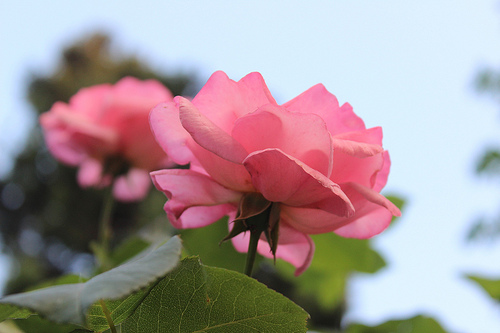

In [ ]:
#glob method to find all files with the .jpg extension in any subdirectory of data_dir
image_count = len(list(data_dir.glob('*/*.jpg'))) ###  [ 'daisy-633' , 'dandelion-898' , 'roses-641' , 'sunflowers-699' , 'tulips-799' ]
print("Number of images is: ",image_count)
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[640]))
#len(roses)

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = '/content/train_dir'
validation_dir = '/content/validation_dir'
test_dir = '/content/test_dir'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_and_val, test = train_test_split(images, test_size=0.01, random_state=42)
        train, val = train_test_split(train_and_val, test_size=0.2, random_state=42)
        #temp, train = train_test_split(train_temp, test_size=0.6, random_state=42)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        for img in train:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img)) # shutil.copy(src, dest)
        for img in val:
            shutil.copy(os.path.join(class_path, img), os.path.join(validation_dir, class_name, img))
        for img in test:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

class_names = train_ds.class_names
print(class_names)

Found 2903 files belonging to 5 classes.
Found 729 files belonging to 5 classes.
Found 38 files belonging to 5 classes.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
"""val_samples = tf.data.experimental.cardinality(val_ds).numpy() *batch_size
print('val_samples:', val_samples)

# Split the validation dataset into validation and test sets
val_size = int(val_samples * 0.5)
test_size = val_samples - val_size
print('val_size:', val_size)
print('test_size:', test_size)
X_VAL = val_ds.take(val_size)
X_TEST = val_ds.skip(val_size).take(test_size)
X_VAL #labels within each data element."""

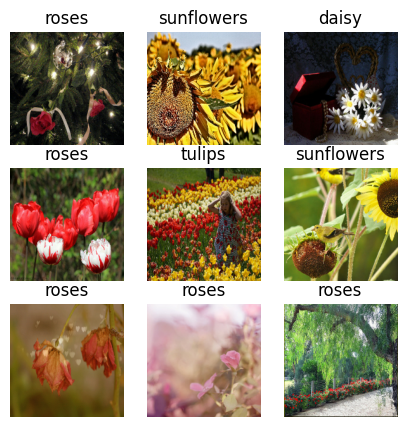

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in val_ds.take(1): #random
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
#optimizes the data pipeline for better performance during model training and evaluation
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#Caches the dataset in memory to speed up subsequent epochs, randomizes the set with buffer_size=1000
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#normalize image data and verify the normalization
resize_and_rescale = Sequential([ Resizing(img_height, img_width), Rescaling(1./255) ])
norm_train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), to_categorical(y, 5)))
norm_val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x),to_categorical(y, 5)))
norm_test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), to_categorical(y, 5)))
image_batch, labels_batch = next(iter(norm_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0003757252 0.99961853


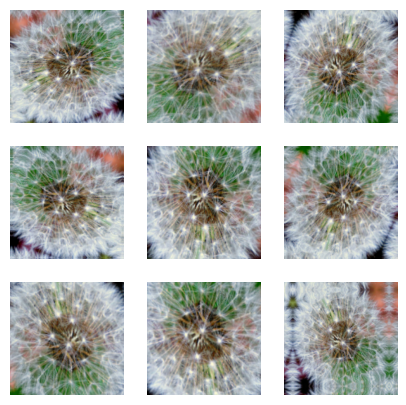

In [19]:
data_augmentation = Sequential([ layers.RandomFlip("horizontal_and_vertical"),
                                      layers.RandomRotation(0.2) , layers.RandomZoom(0.2),
                                      layers.RandomContrast(0.1)
                                      ] )
plt.figure(figsize=(5, 5))
for images, _ in norm_train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy())
    plt.axis("off")

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [20, 40, 60]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(norm_train_ds) # .fit() accepts numpy or df only not tensors
best_params = grid_search.best_params_
best_params

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler ,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2,l1,l1_l2
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications import ResNet50 ,VGG19,ConvNeXtBase,InceptionResNetV2

InceptionResnetv2_model = ConvNeXtBase(weights='imagenet',  include_top=False, input_shape=(img_height, img_width, 3))
# Unfreeze some layers of ResNet50
for layer in InceptionResnetv2_model.layers[-5:]:
    layer.trainable = True
# Freeze the other layers of ResNet50
for layer in InceptionResnetv2_model.layers[:-5]:
    layer.trainable = False

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

callback = EarlyStopping(monitor='val_loss', mode='min',
                               patience= 10, restore_best_weights=True, verbose=1)

RP = ReduceLROnPlateau(monitor='val_loss', patience= 5, verbose= 2, min_lr= 0.0001, factor= 0.1)
#The factor by which the learning rate will be reduced
model = Sequential([ Input(shape=(180, 180, 3)), InceptionResnetv2_model,
                     Conv2D( 16 , (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D(strides=(1,1),pool_size=(2,2)),
                     Conv2D( 32 , (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D(strides=(1,1),pool_size=(2,2)),
                     Conv2D( 64 , (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D(strides=(1,1),pool_size=(2,2)),
                     Conv2D( 128, (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D(strides=(1,1),pool_size=(2,2)),
                     Flatten(), BatchNormalization(),Dropout(0.5),
                     Dense(50,activation='relu',kernel_regularizer=l1_l2( 0.05 )),
                     BatchNormalization(), Dropout(0.5),
                     Dense(5, activation = 'softmax',kernel_regularizer=l1_l2( 0.05 ))
                    ])
model.compile(optimizer=Adam(learning_rate = 0.003), loss= 'CategoricalCrossentropy', metrics=['accuracy'])
#from_logits=True ,loss fn will apply softmax internally
#val_accuracy: 0.6 before augmentation
#accuracy: 0.7595 -- val_accuracy: 0.7180 after augmentation

In [ ]:
start_time = time.time()
history = model.fit( norm_train_ds, validation_data= norm_val_ds, epochs=30, callbacks=[callback,RP])
end_time = time.time()
print("Time taken: {} seconds", end_time - start_time)

Epoch 1/30
29/91 ━━━━━━━━━━━━━━━━━━━━ 1:29:56 87s/step - accuracy: 0.4294 - loss: 28.5303

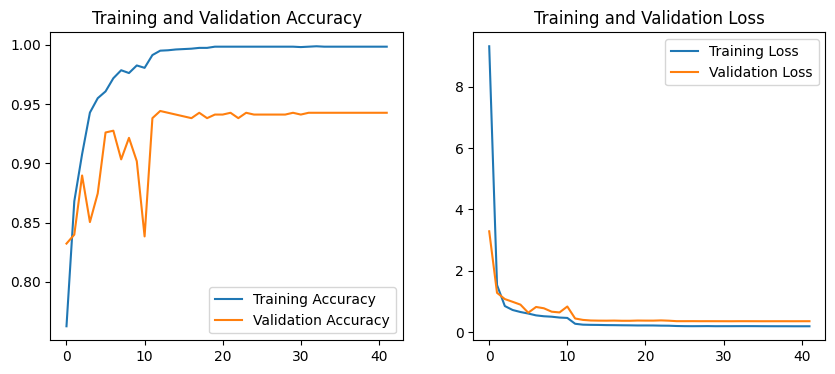

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_y = []
for images, labels in norm_test_ds:
    test_y.extend(labels.numpy())
test_y = np.array(test_y)
m = len(test_y)
pred_test = model.predict(test_ds)
pred_test = np.argmax(pred_test ,axis=1)
test_acc = np.sum((pred_test == test_y)/m )
print("Test accuracy: ",test_acc*100)
print("pred_test", pred_test[1:10])
print("test_y", test_y[1:10])
pred_test.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step
Test accuracy:  18.157181571815716
pred_test [4 4 2 2 0 2 4 4 2]
test_y [1 1 0 2 0 0 4 0 4]


(369,)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
cm =  pd.DataFrame( confusion_matrix( test_y, pred_test, labels=[0,1]), index=['non-cat','cat'], columns=['non-cat','cat'] )
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d") # add annotations to each cell on heatmap as integers
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
plt.title("Confusion Matrix")
plt.show()
print(confusion_matrix( test_y, pred_test))

In [ ]:
report= classification_report(test_y, pred_test ,labels=[1,0],target_names=['cat','non-cat'],output_dict=True ) #row vectors
df = pd.DataFrame(report).transpose()
print(df.round(2))